In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-09-06 09:27:55.384805: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [3]:
ds = tfds.load("fashion_mnist",split="train")

2022-09-06 09:27:57.570815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
ds.as_numpy_iterator().next()["label"]

2022-09-06 09:27:57.671520: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2

# 2. Visualize and Build dataset #

In [5]:
# Do some data transformation
import numpy as np

In [6]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Getting data out of the pipeline
dataiterator.next()

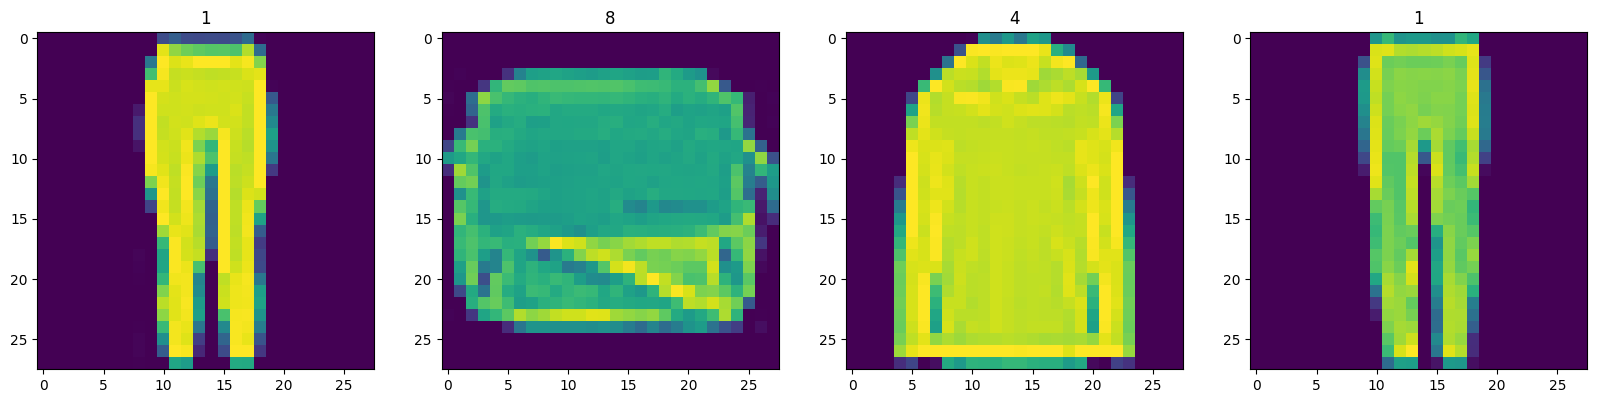

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample["image"]))
    ax[idx].title.set_text(sample["label"])

In [9]:
# scale and return images only
def scale_images(data):
    image = data["image"]
    return image / 255

In [10]:
# reload the dataset
ds = tfds.load("fashion_mnist", split="train")
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [11]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network #

**3.1 import Modelling Components**

In [12]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

**3.2 Build Generator**

In [13]:
def build_generator():
    model = Sequential()
    # Takes in random values and reshape it to 7x7x128
    # Beginings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    # Cater for non linearities in our model
    model.add(LeakyReLU(0.2))
    # Gives out our spacial quality
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 (Double the spacial quality 14x14x128)
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128,4, padding="same"))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1,4,padding="same", activation="sigmoid"))
    return model

In [14]:
build_generator().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [15]:
gen = build_generator()

In [16]:
img = gen.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 177ms/step


In [17]:
img

array([[[[0.49582624],
         [0.48896906],
         [0.48275632],
         ...,
         [0.4838494 ],
         [0.4901204 ],
         [0.49098852]],

        [[0.5022052 ],
         [0.50225884],
         [0.4972838 ],
         ...,
         [0.49226773],
         [0.49521163],
         [0.494158  ]],

        [[0.49167424],
         [0.49626282],
         [0.49461415],
         ...,
         [0.50090295],
         [0.4957368 ],
         [0.48935747]],

        ...,

        [[0.49966347],
         [0.4981614 ],
         [0.5060958 ],
         ...,
         [0.49938217],
         [0.49536875],
         [0.49583748]],

        [[0.5029569 ],
         [0.5094742 ],
         [0.5108565 ],
         ...,
         [0.5040549 ],
         [0.49844807],
         [0.49820584]],

        [[0.50040954],
         [0.50177926],
         [0.5045988 ],
         ...,
         [0.5089086 ],
         [0.50113076],
         [0.50019765]]],


       [[[0.491452  ],
         [0.49667823],
         [0.49

In [18]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 50ms/step


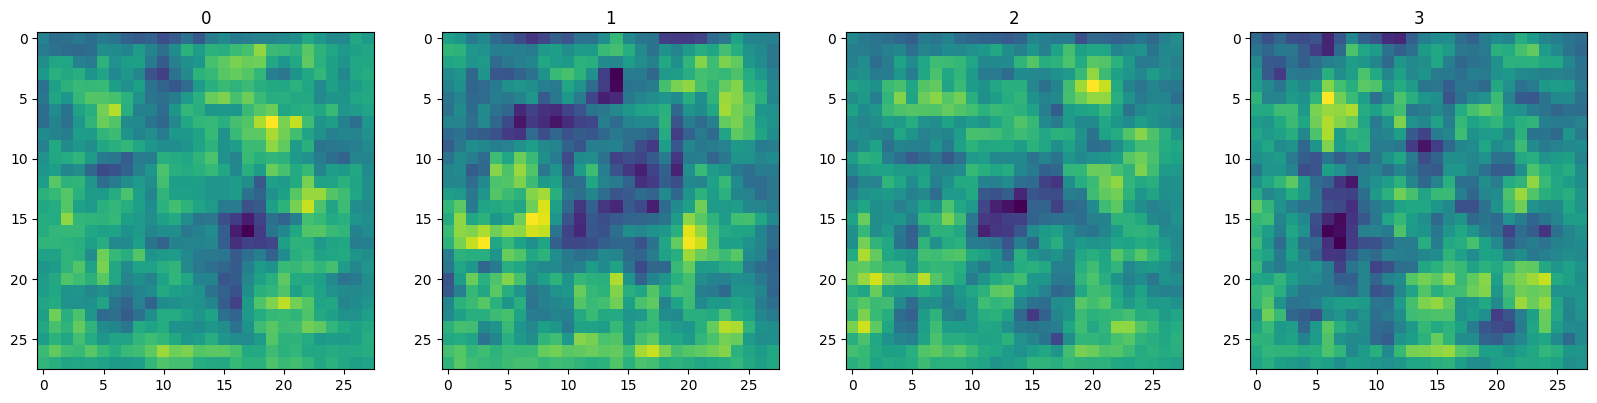

In [19]:
# Generate new fashion
img = gen.predict(np.random.randn(4,128,1))
# Setup the subplot for formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop 4 times and get images
for idx,img in enumerate(img):
    # Plot the image using specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

**3.3 Build Discriminator**

In [20]:
def build_discriminator():
    model = Sequential()
    
    # First conv Block
    model.add(Conv2D(32, 5, input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third conv block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to Dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))
    
    
    return model

In [21]:
discriminator = build_discriminator()

In [22]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)      

In [23]:
img = gen.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 56ms/step


In [24]:
discriminator.predict(img)

1/1 [==============================] - 0s 65ms/step


array([[0.48671198],
       [0.4867255 ],
       [0.48651266],
       [0.4866263 ]], dtype=float32)

# 4. Construct Training Loop #

**4.1 Setup Losses and Optimizers**

In [25]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [26]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

**4.2 Build Subclassed model**

In [27]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [28]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
        
        
    def compile(self,g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((6,128,1)), training=False)
        
        # Train the discriminator
        # Start calculating gradients or monitoring each one of the functions
        # tf.GradientTape() function allows us to calculate all of the operations
        #that are happening by using our deep neural network
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator
            # Training is set to True to activate Dropout layers
            # If Training is set to false Dropout layers will not activate
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)
            
            # Add some noise to the True outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate the loss -BINARYCROSSENTROPY
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
            
        # Apply backpropagation - nn Learn
        # Calculate Gradient with respect to the loss for each one of our trainable variables
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        # Apply gradient using Back Propagation to the respective trainable variables
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            
            # Calculate loss - trick to training to fake out the discriminator
            # real values, predicted values
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss" : total_d_loss, "g_loss" : total_g_loss}
        

In [29]:
# Create an instance of subclassed model
generator = build_generator()
fashgan = FashionGAN(generator, discriminator)

In [30]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

**4.3 Build callback**

In [31]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [32]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
        self.times = []
        # use this value as reference to calculate cummulative time taken
        #self.timetaken = time.clock()
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *=255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join("images" ,f"generated_img_{epoch}_{i}.png"))

# Train

In [33]:
#hist = fashgan.fit(ds, epochs=2, callbacks=[ModelMonitor()])

In [35]:
generator.load_weights("generatormodel.h5")

ValueError: axes don't match array